# CVX Project - Part 1 | Spring 2019
### Comparison of Different Convergence Algorithms for Unstructured Sparsity

In [1]:
import numpy as np 
from scipy.sparse import random as sprandn
import matplotlib.pyplot as plt

### Defining some critical constants needed along the way
These values are shown to work well with the given algorithms. Also we compute the Gram Matrrix for A'A so that we can use it directly.

In [26]:
m = 1000
n = 1000
maxit = 10000
V = 1e-4
W   = 1e-2 

A = np.matrix(np.random.randn(m,n))
A = (A-np.mean(A,0))/np.std(A,0)
x_r = sprandn(n,1,density=0.05)
b = A*x_r + np.sqrt(0.001)*np.matrix(np.random.randn(m,1))
ATA  = A.T*A
ATb  = A.T*b

Once the constants have been defined, we now proceed to write out the helper functions for simple L1-norm regularized sparse source localization. The objective is simply coded using the 1-norm, gradient is easily found, 

In [27]:
def objective(A,x,b,gamma):
    return f(A,x,b) + gamma*np.sum(np.abs(x))

def f(A,x,b):
    return 0.5*(np.linalg.norm(A*x-b)**2)

def gradf(ATA,x,ATb):
    return ATA*x-ATb 

def uppbd(A,ATA,ATb,x,x_1,b,lK):
    xd = x_1 - x
    return f(A,x,b) + 1.0/(2.0*lK)* np.sum(np.multiply(xd,xd)) + gradf(ATA,x,ATb).T*xd 
    
def proxop(zeta,lamdaK):
    f = np.matrix(np.zeros(np.shape(zeta)))
    return np.multiply(np.sign(zeta),np.maximum(np.abs(zeta)-lamdaK,f))

def proxf(ATA,zeta,ATb,W,n):
    return np.linalg.inv(W*np.identity(n)+ATA)*(ATb + 0.01*zeta)

### Defining the Solvers
Now we can proceed to write 3 different solvers - the PGD, APGD and the ADMM. The methodology is well documented in most online resources. But these are custom coded.

In [28]:
def PGD(maxit,lK,g,AtA,Atb,A,beta,b,V):
    x = np.matrix(np.zeros((np.shape(A)[1],1)))
    obj = []
    for k in range(maxit):
        while True:
            xr = proxop(x-lK*gradf(AtA,x,Atb),lK*g)
            if f(A,xr,b) <= uppbd(A,AtA,Atb,x,xr,b,lK):
                break
            else:
                lK = beta*lK
        obj.append(objective(A,xr,b,g))
        if k > 1 and np.linalg.norm(objective(A,xr,b,g) - objective(A,x,b,g)) < V:
            break
        x = xr
    return obj,xr

def APGD(maxit,lK,g,AtA,Atb,A,beta,b,V):
    x = np.matrix(np.zeros((np.shape(A)[1],1)))
    xp = x
    obj = []
    for k in range(maxit):
        y = x + (1/(k+1)) * (x-xp)
        while True:
            xr = proxop(y-lK*gradf(AtA,y,Atb),lK*g)
            if f(A,xr,b) <= uppbd(A,AtA,Atb,y,xr,b,lK):
                break
            else:
                lK = beta*lK
        obj.append(objective(A,xr,b,g))
        if k > 1 and np.linalg.norm(objective(A,xr,b,g) - objective(A,x,b,g)) < V:
            break
        xp = x
        x = xr
    return obj,xr

def ADMM(maxit,lK,g,ATA,ATb,A,b,V,W,n):
    ldr = 1/lK
    x = np.matrix(np.random.randn(n,1))
    z = np.matrix(np.random.randn(n,1))
    t = np.matrix(np.random.randn(n,1))
    obj = []
    for k in range(maxit):
        xr = proxf(ATA,(z-t),ATb,W,n)
        zr = proxop(xr+t,(lK*g)/W) 
        tr = t + W*(xr - zr)
        ls = f(A,xr,b)+ g*np.sum(np.abs(zr))
        obj.append(ls)
        lsold = f(A,x,b)+ g*np.sum(np.abs(z))
        if k > 1 and np.linalg.norm(ls - lsold) < V:
            break
        z = zr
        x = xr
        t = tr        
    return obj, xr

### Running the defined solvers
Finally we can run the three solvers and get the results stored in the **obj*** variables.

In [29]:
lK = 1
be = 0.5
g =  0.01

obj1,d = PGD(maxit,lK,g,ATA,ATb,A,be,b,V)
obj2,d = APGD(maxit,lK,g,ATA,ATb,A,be,b,V)
obj3,d = ADMM(maxit,lK,g,ATA,ATb,A,b,V,W,n)

### Plotting the Convergence Graphs per Method
The obj* variables from the above code captures the array of loss values per iteration. These are then plotted on the same graph to show speed of convergence relative to other methods.

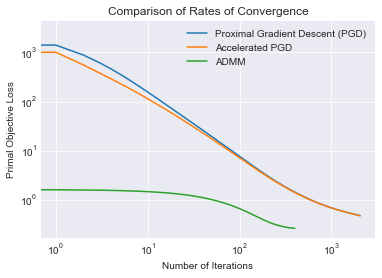

In [30]:
plt.style.use('seaborn-darkgrid')
plt.plot(range(len(obj1)), obj1,range(len(obj2)), obj2,range(len(obj3)), obj3)
plt.title('Comparison of Rates of Convergence')

plt.xlabel('Number of Iterations')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Primal Objective Loss')
plt.legend(['Proximal Gradient Descent (PGD)', 'Accelerated PGD','ADMM'])

We also want to make sure that our ADMM implementation is not dead. So we plot just that and sure enough the convergence is legitimate.

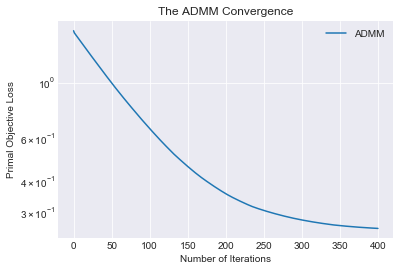

In [31]:
plt.plot(range(len(obj3)), obj3)
plt.title('The ADMM Convergence')

plt.yscale('log')
plt.xlabel('Number of Iterations')
plt.ylabel('Primal Objective Loss')
plt.legend(['ADMM'])

Lastly, we emphasize the improvement in accelerated PGD vs. PGD. In fact for our chosen parameters the differences are not significant. Increasing the acceleration may help converge faster. Changing the standard 1/k factor to 1/k+3 we observe that the accelerated method does indeed converge faster!

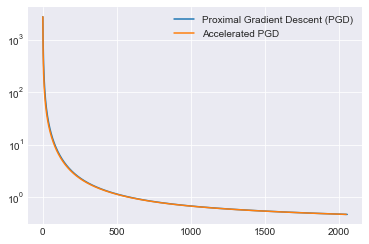

In [32]:
plt.plot(range(len(obj1)), obj1 ,range(len(obj2)), obj2)
plt.yscale('log')
plt.legend(['Proximal Gradient Descent (PGD)', 'Accelerated PGD'])

In [33]:
def APGD_r(maxit,lK,g,AtA,Atb,A,beta,b,V, r):
    x = np.matrix(np.zeros((np.shape(A)[1],1)))
    xp = x
    obj = []
    for k in range(maxit):
        y = x + (r) * (x-xp)
        while True:
            xr = proxop(y-lK*gradf(AtA,y,Atb),lK*g)
            if f(A,xr,b) <= uppbd(A,AtA,Atb,y,xr,b,lK):
                break
            else:
                lK = beta*lK
        obj.append(objective(A,xr,b,g))
        if k > 1 and np.linalg.norm(objective(A,xr,b,g) - objective(A,x,b,g)) < V:
            break
        xp = x
        x = xr
    return obj,xr

Text(0.5, 1.0, 'Aggressive Acceleration implies slower convergence or OOB')

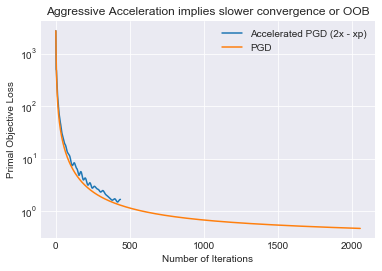

In [34]:
obj1,d = APGD_r(maxit,lK,g,ATA,ATb,A,be,b,V,1)
obj2,d = APGD_r(maxit,lK,g,ATA,ATb,A,be,b,V,0)

plt.plot(range(len(obj1)), obj1,range(len(obj2)), obj2)
plt.yscale('log')
plt.legend(['Accelerated PGD (2x - xp)','PGD'])
plt.xlabel('Number of Iterations')
plt.ylabel('Primal Objective Loss')
plt.title('Aggressive Acceleration implies slower convergence or OOB')